<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com). Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_tutorial/).</i></small>

# Supervised Learning In-Depth: Support Vector Machines

Previously we introduced supervised machine learning.
There are many supervised learning algorithms available; here we'll go into brief detail one of the most powerful and interesting methods: **Support Vector Machines (SVMs)**.

In [53]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
# use seaborn plotting defaults
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.datasets.samples_generator import make_circles
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, ShuffleSplit, train_test_split
#this is if you want to do the PCA
from sklearn.decomposition import PCA
#np.set_printoptions(threshold='nan')
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

In [26]:

df = pd.read_csv(r'/Users/david/Downloads/ALLUKAuctions.csv', error_bad_lines=False,encoding = "ISO-8859-1")
df.head()
df["Auction Date"] = pd.to_datetime(df["Auction Date"], infer_datetime_format=True)
#df["Yield Tail (bp)"]

In [27]:
#df = df[(df["Maturity Bracket"] == "Long") ]

df = df[(df["Maturity Bracket"] == "Long") | (df["Maturity Bracket"] == "Medium") | (df["Maturity Bracket"] == "Short")]

In [28]:
np.set_printoptions(threshold=np.nan)
#df_mod = df.dropna()

df_mod = df[["Bid to Cover Ratio at Auction","Yield Tail (bp)","Yield corresponding to AAP (%)","Maturity Bracket","Auction Date"]]
df_mod = df_mod.dropna()
df_mod = df_mod[df_mod["Yield Tail (bp)"] < 10.0]
bc = df_mod["Bid to Cover Ratio at Auction"]
yc = df_mod["Yield corresponding to AAP (%)"]
yt = df_mod["Yield Tail (bp)"]
dt = df_mod["Auction Date"]
#X = np.array ([bc.values, yt.values]).T
#X_orig = np.array ([bc.values, np.array(dt.values, dtype=float), yt.values, yc.values]).T
do_pca = True
#if do_pca:
X_orig = np.array ([bc.values, yc.values, yt.values, np.array(dt.values, dtype=float)]).T
#else:
#    X_orig = np.array ([bc.values, yc.values]).T

X_orig = preprocessing.scale(X_orig)
#miss out the massive outlier
#yt
ave_yt = yt.rolling(5).mean()
yt = ave_yt.shift(1) - yt
yt = yt[5:]
#remove the first 5 from each of the arrays
X_orig = X_orig[5:]
dt = dt[5:]
print(X_orig.shape)
print(yt.shape)
#plt.scatter(dt.values,yt.values, s=50, cmap='spring')
#plt.plot(dt.values, yt.values)

cat = (yt > 0)
print (yt[:10])
print(cat[:10])
c = cat
le = preprocessing.LabelEncoder()
print(c.unique())
le.fit(c.unique())
c_vals = le.transform(c.values)
y = c_vals
print(y[:10])
test_size = 0.2
X_train, X_out, y_train, y_out = train_test_split(X_orig, y,test_size=test_size)
#X_train, X_out, y_vals, y_out_vals = train_test_split(X_orig, yt.values,test_size=test_size)
X_orig = X_train
y = y_train
print(X_train.shape, X_out.shape, y_train.shape, y_out.shape)

(431, 4)
(431,)
13    0.26
15    0.36
17   -0.42
18   -0.42
20   -0.66
22   -0.14
24   -0.06
25    0.68
27   -0.84
28    0.72
Name: Yield Tail (bp), dtype: float64
13     True
15     True
17    False
18    False
20    False
22    False
24    False
25     True
27    False
28     True
Name: Yield Tail (bp), dtype: bool
[True False]
[1 1 0 0 0 0 0 1 0 1]
(344, 4) (87, 4) (344,) (87,)


In [29]:
dim = 2
pca = PCA(dim).fit(X_orig)
print(pca.explained_variance_ratio_)
print(pca.components_)
X_pca = pca.transform(X_orig)
X = X_orig
X_out_pca = pca.transform(X_out)


[ 0.4411745   0.32249451]
[[ 0.08068708  0.67673352  0.35534788 -0.6397259 ]
 [-0.72097729 -0.06676537  0.65876468  0.20436051]]


Support Vector Machines (SVMs) are a powerful supervised learning algorithm used for **classification** or for **regression**. SVMs are a **discriminative** classifier: that is, they draw a boundary between clusters of data.

Let's show a quick example of support vector classification. First we need to create a dataset:

In [30]:
def fitandshowresults(clf, X_train, X_test):
    clf.fit(X_train, y)
    y_predict = clf.predict(X_train)
    #cm = confusion_matrix(y_predict, y)

    #print(cm)
    #print("score: " , clf.score(X_test,y_out))
    cv = ShuffleSplit(n_splits=10, test_size=0.1,random_state=0)

    test_scores = cross_val_score(clf, X_train, y, cv=cv, n_jobs=2)
    print(test_scores)
    print ("cv mean",np.mean(test_scores))
    out_samp = clf.score(X_test, y_out)
    print ("out score", out_samp)

In [87]:
def fitandshowresultsVoting(eclf, X_train, X_test):
    eclf.fit(X_train, y)
    #y_predict = clf.predict(X_train)
    #print (eclf.estimators_)
    e_list = eclf.estimators_ + [eclf]
    #l_list = len(eclf.estimators) + 1
    #print (e_list)
    #cm = confusion_matrix(y_predict, y)
    for clf in e_list:
        #clf.fit(X_train, y)
        cv = ShuffleSplit(n_splits=10, test_size=0.1,random_state=0)
        #scores = cross_val_score(clf, X_train, y, cv=cv, scoring='accuracy')
        scores = cross_val_score(clf, X_train, y, cv=cv)
        out_samp = clf.score(X_test, y_out)
        print("Accuracy: %0.2f (+/- %0.2f) [%s] Out: %0.2f" % (scores.mean(), scores.std(), type(clf), out_samp))
    #print(cm)
    #print("score: " , clf.score(X_test,y_out))
    

    #test_scores = cross_val_score(clf, X_train, y, cv=cv, n_jobs=2)
    #print(test_scores)
    #print ("cv mean",np.mean(test_scores))
    #out_samp = clf.score(X_test, y_out)
    #print ("out score", out_samp)

In [31]:
#  # "Support Vector Classifier"
clf = SVC(kernel='rbf', C=1)
fitandshowresults(clf, X, X_out)

[ 0.8         0.65714286  0.88571429  0.88571429  0.77142857  0.8
  0.88571429  0.85714286  0.62857143  0.74285714]
cv mean 0.791428571429
out score 0.816091954023


To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [32]:
#  # "Support Vector Classifier"
clf = SVC(kernel='linear', C=1)
fitandshowresults(clf, X, X_out)

[ 0.85714286  0.68571429  0.82857143  0.85714286  0.8         0.82857143
  0.88571429  0.8         0.68571429  0.82857143]
cv mean 0.805714285714
out score 0.770114942529


In [35]:
#  # "Support Vector Classifier"
clf = SVC(kernel='rbf', C=1)
fitandshowresults(clf, X_pca, X_out_pca)

[ 0.8         0.65714286  0.82857143  0.8         0.77142857  0.8
  0.82857143  0.85714286  0.6         0.8       ]
cv mean 0.774285714286
out score 0.793103448276


In [36]:
#  # "Support Vector Classifier"
clf = SVC(kernel='linear', C=1)
fitandshowresults(clf, X_pca, X_out_pca)

[ 0.77142857  0.74285714  0.77142857  0.77142857  0.74285714  0.8         0.8
  0.77142857  0.6         0.74285714]
cv mean 0.751428571429
out score 0.827586206897


In [38]:
#  # "Support Vector Classifier"
logreg = linear_model.LogisticRegression(C=1e5)
fitandshowresults(logreg, X, X_out)

[ 0.88571429  0.71428571  0.85714286  0.91428571  0.8         0.82857143
  0.88571429  0.8         0.71428571  0.82857143]
cv mean 0.822857142857
out score 0.793103448276


In [42]:
#  # "Support Vector Classifier"
forest = RandomForestClassifier(n_estimators = 10)
fitandshowresults(forest, X, X_out)

[ 0.82857143  0.82857143  0.82857143  0.91428571  0.82857143  0.88571429
  0.68571429  0.85714286  0.8         0.85714286]
cv mean 0.831428571429
out score 0.896551724138


In [50]:
#  # "Support Vector Classifier"
forest = ExtraTreesClassifier(n_estimators = 10)
fitandshowresults(forest, X, X_out)

[ 0.88571429  0.77142857  0.85714286  0.74285714  0.85714286  0.71428571
  0.85714286  0.91428571  0.68571429  0.71428571]
cv mean 0.8
out score 0.885057471264


In [44]:
#  # "Support Vector Classifier"
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
#forest = RandomForestClassifier(n_estimators = 10)
fitandshowresults(clf, X, X_out)

[ 0.85714286  0.85714286  0.82857143  0.82857143  0.74285714  0.85714286
  0.85714286  0.91428571  0.74285714  0.91428571]
cv mean 0.84
out score 0.862068965517


In [52]:
#  # "Support Vector Classifier"
clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0)
#forest = RandomForestClassifier(n_estimators = 10)
fitandshowresults(clf, X, X_out)

[ 0.85714286  0.8         0.8         0.8         0.74285714  0.8
  0.82857143  0.94285714  0.74285714  0.88571429]
cv mean 0.82
out score 0.862068965517


In [91]:
#  # "Support Vector Classifier"
clf1 = SVC(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = ExtraTreesClassifier()

vclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
#forest = RandomForestClassifier(n_estimators = 10)
fitandshowresultsVoting(vclf, X, X_out)

Accuracy: 0.79 (+/- 0.09) [<class 'sklearn.svm.classes.SVC'>] Out: 0.82
Accuracy: 0.83 (+/- 0.06) [<class 'sklearn.ensemble.forest.RandomForestClassifier'>] Out: 0.82
Accuracy: 0.81 (+/- 0.06) [<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>] Out: 0.84
Accuracy: 0.84 (+/- 0.09) [<class 'sklearn.ensemble.voting_classifier.VotingClassifier'>] Out: 0.82


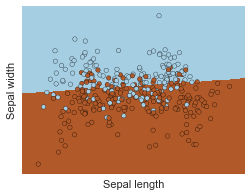

[[100  38]
 [ 46 160]]
score:  0.755813953488
[ 0.8         0.71428571  0.62857143  0.6         0.68571429  0.71428571
  0.85714286  0.74285714  0.77142857  0.8       ]
cv mean 0.731428571429
out score 0.747126436782


In [16]:
logreg = linear_model.LogisticRegression(C=1e5)
#logreg = linear_model.LinearRegression(fit_intercept=False)

logreg.fit(X, y)
h = 0.02
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()
fitandshowresults(logreg)